Current working directory: C:\Users\user\Desktop\Investment Banking Intern
os.getcwd() returns an object of type <class 'str'>


C:\Users\user\AppData\Local\Temp\ipykernel_6192\689076199.py:20: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  date_time = pd.to_datetime(date_time)
C:\Users\user\AppData\Local\Temp\ipykernel_6192\689076199.py:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv('Nat_Gas.csv', parse_dates=['Dates'])


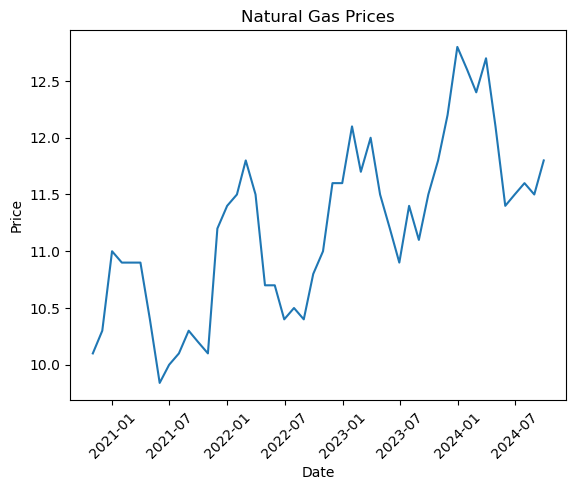

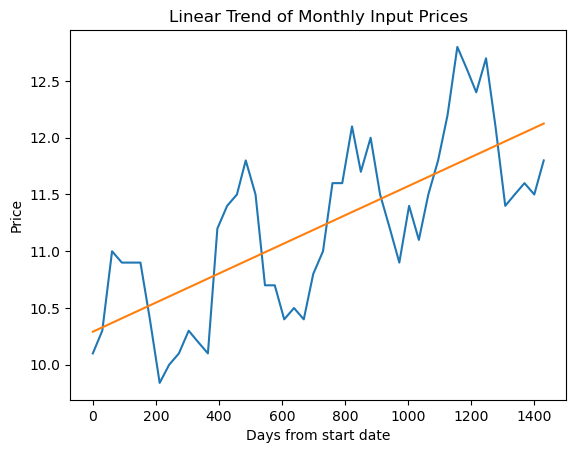

0.001282373598760221 10.29104112595228


In [1]:
import os

cwd = os.getcwd()

print("Current working directory: {0}".format(cwd))

print ("os.getcwd() returns an object of type {0}".format(type(cwd)))

# copy the filepath 
os.chdir("C:\\Users\\user\\Desktop\\Investment Banking Intern\\Quantitative Research")

# let's jump into task 1

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import date, timedelta

date_time = ["10-2020", "11-2020", "12-2020"]
date_time = pd.to_datetime(date_time)
data = [1, 2, 3]

df = pd.read_csv('Nat_Gas.csv', parse_dates=['Dates'])
prices = df['Prices'].values
dates = df['Dates'].values

# plot prices against dates
fig, ax = plt.subplots()
ax.plot_date(dates, prices, '-')
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.set_title('Natural Gas Prices')
ax.tick_params(axis='x', rotation=45)

plt.show()

# From the plot - we can see the prices have a natural frequency of around a year, but trend upwards. 
# We can do a linear regression to get the trend, and then fit a sin function to the variation in each year.

# First we need the dates in terms of days from the start, to make it easier to interpolate later.
start_date = date(2020,10,31)
end_date = date(2024,9,30)
months = []
year = start_date.year
month = start_date.month + 1
while True:
    current = date(year, month, 1) + timedelta(days=-1)
    months.append(current)
    if current.month == end_date.month and current.year == end_date.year:
        break
    else:
        month = ((month + 1) % 12) or 12
        if month == 1:
            year += 1
        
days_from_start = [(day - start_date ).days for day in months]

# Simple regression for the trend will fit to a model y = Ax + B. The estimator for the slope is given by \hat{A} = \frac{\sum (x_i - \bar{x})(y_i - \bar{y})}{\sum (x_i - \bar{x})^2}, 
# and that for the intercept by \hat{B} = \bar{y} - hat{A} * \xbar

def simple_regression(x, y):
    xbar = np.mean(x)
    ybar = np.mean(y)
    slope = np.sum((x - xbar) * (y - ybar))/ np.sum((x - xbar)**2)
    intercept = ybar - slope*xbar
    return slope, intercept

time = np.array(days_from_start)
slope, intercept = simple_regression(time, prices)

# Plot linear trend
plt.plot(time, prices)
plt.plot(time, time * slope + intercept)
plt.xlabel('Days from start date')
plt.ylabel('Price')
plt.title('Linear Trend of Monthly Input Prices')
plt.show()
print(slope, intercept)

# From this plot we see the linear trend has been captured. Now to fit the intra-year variation. 
# Given that natural gas is used more in winter, and less in summer, we can guess the frequency of the price movements to be about a year, or 12 months.
# Therefore we have a model y = Asin( kt + z ) with a known frequency.Rewriting y = Acos(z)sin(kt) + Asin(z)cos(kt), 
# we can use bilinear regression, with no intercept, to solve for u = Acos(z), w = Asin(z)

sin_prices = prices - (time * slope + intercept)
sin_time = np.sin(time * 2 * np.pi / (365))
cos_time = np.cos(time * 2 * np.pi / (365))

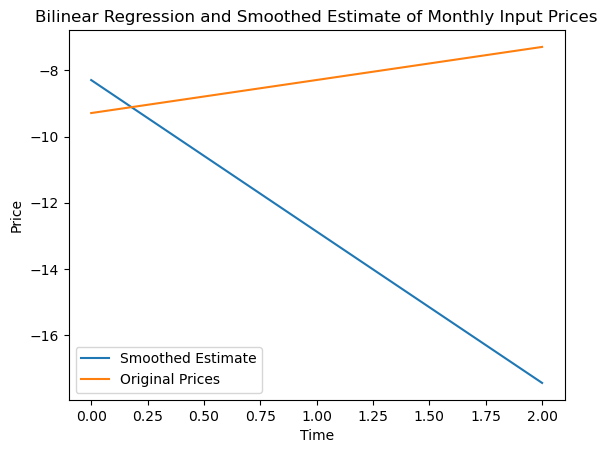

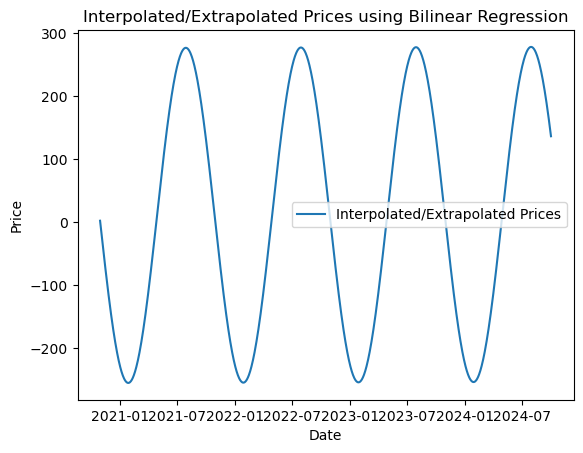

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date, timedelta

# Placeholder values for undefined variables
start_date = pd.Timestamp(date(2020, 10, 31))
end_date = pd.Timestamp(date(2024, 9, 30))
prices = np.array([1, 2, 3])  # Placeholder for prices, replace with your data

# Ensure that time has the same length as prices
time = np.arange(len(prices))

# Bilinear regression
sin_prices = prices - (time * slope + intercept)
sin_time = np.sin(time * 2 * np.pi / 365)
cos_time = np.cos(time * 2 * np.pi / 365)

def bilinear_regression(y, x1, x2):
    slope1 = np.sum(y * x1) / np.sum(x1 ** 2)
    slope2 = np.sum(y * x2) / np.sum(x2 ** 2)
    return slope1, slope2

slope1, slope2 = bilinear_regression(sin_prices, sin_time, cos_time)
amplitude = np.sqrt(slope1 ** 2 + slope2 ** 2)
shift = np.arctan2(slope2, slope1)

# Plot smoothed estimate of full dataset
plt.plot(time, amplitude * np.sin(time * 2 * np.pi / 365 + shift), label='Smoothed Estimate')
plt.plot(time, sin_prices, label='Original Prices')
plt.title('Bilinear Regression and Smoothed Estimate of Monthly Input Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

# Define the interpolation/extrapolation function
def interpolate(date):
    days = (date - start_date).days
    interpolated_price = amplitude * np.sin(days * 2 * np.pi / 365 + shift) + days * slope + intercept
    return interpolated_price

# Create a range of continuous dates from start date to end date
continuous_dates = pd.date_range(start=start_date, end=end_date, freq='D')

# Plot the interpolated/extrapolated prices
plt.plot(continuous_dates, [interpolate(date) for date in continuous_dates], label='Interpolated/Extrapolated Prices')
plt.title('Interpolated/Extrapolated Prices using Bilinear Regression')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


In [3]:
import statsmodels.api as sm
from statsmodels import regression

# Print the DataFrame to inspect the 'Dates' column
print("Original DataFrame:")
print(df)

# Function to print the price for a given date
def print_price_for_date(input_date):
    try:
        input_date = pd.to_datetime(input_date)
        print("DataFrame after conversion:")
        df['Dates'] = pd.to_datetime(df['Dates'])
        print(df)
        
        price = df.loc[df['Dates'] == input_date, 'Prices'].values[0]
        print(f'The price on {input_date} is: {price}')
    except IndexError:
        print(f'No data found for {input_date}')

# Example usage
input_date = input('Enter the date (YYYY-MM-DD): ')
print_price_for_date(input_date)

Original DataFrame:
        Dates  Prices
0  2020-10-31   10.10
1  2020-11-30   10.30
2  2020-12-31   11.00
3  2021-01-31   10.90
4  2021-02-28   10.90
5  2021-03-31   10.90
6  2021-04-30   10.40
7  2021-05-31    9.84
8  2021-06-30   10.00
9  2021-07-31   10.10
10 2021-08-31   10.30
11 2021-09-30   10.20
12 2021-10-31   10.10
13 2021-11-30   11.20
14 2021-12-31   11.40
15 2022-01-31   11.50
16 2022-02-28   11.80
17 2022-03-31   11.50
18 2022-04-30   10.70
19 2022-05-31   10.70
20 2022-06-30   10.40
21 2022-07-31   10.50
22 2022-08-31   10.40
23 2022-09-30   10.80
24 2022-10-31   11.00
25 2022-11-30   11.60
26 2022-12-31   11.60
27 2023-01-31   12.10
28 2023-02-28   11.70
29 2023-03-31   12.00
30 2023-04-30   11.50
31 2023-05-31   11.20
32 2023-06-30   10.90
33 2023-07-31   11.40
34 2023-08-31   11.10
35 2023-09-30   11.50
36 2023-10-31   11.80
37 2023-11-30   12.20
38 2023-12-31   12.80
39 2024-01-31   12.60
40 2024-02-29   12.40
41 2024-03-31   12.70
42 2024-04-30   12.10
43 2024-05-3